## Predict cloud coverage

- Predicting cloud cover in a short time span of 120 minutes is very challenging.
- On this time scale, changes in local cloud cover are driven by a combination of dynamical and physical parameters such as wind speed, wind direction sea-level pressure, humidity, and temperature over the asset of our interest.
- Short interval cloud cover prediction requires accurate estimates of cloud motion and presence using weather data and sky camera images or physics-based&nbsp;weather models or a combination of both. 

### Goal:
#### Predict the percentage of total cloud coverage for the next upcoming intervals using the available weather and sky camera data.  

We are expected to predict the total cloud coverage as a percentage of the open sky for a fixed field of view at 4 horizon intervals of 30, 60, 90, and 120 minutes from a 6-hour window of historical data.  

While validating and testing the predictions made by model, we are not supposed to consider **DATE (MM/DD)** and **MST** in a day as input features.  
So the task at hand is to make a model which will be generic throughout the year for any day and any time.  

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
PATH_FOLDER_DATASET = "dataset"
PATH_FOLDER_TRAINING = os.path.join(PATH_FOLDER_DATASET,"train")

Let's import training dataset

In [3]:
weather_df = pd.read_csv(os.path.join(PATH_FOLDER_TRAINING, "train.csv"))
weather_df.head(5)

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,1/1,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,1/1,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,1/1,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,-1,7.20,285.5,806.762,0.0,0.182,0.0,0.0


In [4]:
weather_df.shape

(527040, 17)

The local weather data was recorded for 366 days for 1 minute frequency, this makes $366\times24\times60 = 527040$ rows, which is correct  

Now the raw sky camera images were recorded at 10 minute frquence for the same duration. Let's see total number of images

In [5]:
import filetype 

images_count = {}
junks_count = {}

for file in os.scandir(PATH_FOLDER_TRAINING):
    if file.is_dir():
        images_count[file.name] = 0
        junks_count[file.name] = 0
        
        for image in os.scandir(file.path):
            if filetype.is_image(image.path):
                images_count[file.name] += 1
            else:
                junks_count[file.name] += 1

junks_count = np.array(list(junks_count.items()), dtype=object)
images_count = np.array(list(images_count.items()), dtype=object)

In [6]:
print("Junk files in image folder: ", junks_count[np.where(junks_count[:, 1] > 0)])
print("Folders with no images recorded: ", images_count[np.where(images_count[:, 1] == 0)][:,0])

Junk files in image folder:  []
Folders with no images recorded:  ['0404' '0405']


Seems like images were not recorded on 4th & 5th April. Maybe we won't be able to consider weather data for these 2 dates during training. Althugh nothing junk found!  


Since images were captured with 10 mins frquency in a day, let's take a peek at image counts per day.

In [7]:
print("Unique image counts per folder (day):")
np.unique(images_count[:,1])

Unique image counts per folder (day):


array([0, 5, 7, 11, 12, 13, 14, 28, 31, 50, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
      dtype=object)

Very irregular!  

### Analyzing Weather Data

In [8]:
weather_df.head(3)

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,1/1,00:00,-0.962276,0.0,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.0,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.0,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0


In [9]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   DATE (MM/DD)                           527040 non-null  object 
 1   MST                                    527040 non-null  object 
 2   Global CMP22 (vent/cor) [W/m^2]        527040 non-null  float64
 3   Direct sNIP [W/m^2]                    527040 non-null  float64
 4   Azimuth Angle [degrees]                527040 non-null  float64
 5   Tower Dry Bulb Temp [deg C]            527040 non-null  float64
 6   Tower Wet Bulb Temp [deg C]            527040 non-null  float64
 7   Tower Dew Point Temp [deg C]           527040 non-null  float64
 8   Tower RH [%]                           527040 non-null  float64
 9   Total Cloud Cover [%]                  527040 non-null  int64  
 10  Peak Wind Speed @ 6ft [m/s]            527040 non-null  

Renaming the features to make them simpler to understand.  
I have researched some information about significance of each feature and devices that they were measured from and documented [here](https://github.com/mrutyunjay17/solar-power-prediction/blob/main/Documentation.md).

In [10]:
ORIGINAL_FEATURE_NAMES = weather_df.columns

CUSTOM_FEATURE_NAMES = {
    'DATE (MM/DD)':'date',
    'MST':'time',  
    'Global CMP22 (vent/cor) [W/m^2]':'pyranometer',
    'Direct sNIP [W/m^2]':'pyroheliometer',  
    'Azimuth Angle [degrees]':'azimuth_angle_deg',
    'Tower Dry Bulb Temp [deg C]':'tower_dry_bulb_temp_deg', 
    'Tower Wet Bulb Temp [deg C]':'tower_wet_bulb_temp_deg',
    'Tower Dew Point Temp [deg C]':'tower_dew_point_deg', 
    'Tower RH [%]':'tower_rh_pct', 
    'Total Cloud Cover [%]':'total_cloud_coverage_pct',
    'Peak Wind Speed @ 6ft [m/s]':'peak_wind_speed_mps', 
    'Avg Wind Direction @ 6ft [deg from N]':'avg_wind_direction_deg',
    'Station Pressure [mBar]':'station_pressure_mbar', 
    'Precipitation (Accumulated) [mm]':'precipitation_mm',
    'Snow Depth [cm]':'snow_depth_cm', 
    'Moisture':'moisture', 
    'Albedo (CMP11)':'albedometer'
}

In [11]:
weather_df.rename(columns=CUSTOM_FEATURE_NAMES, inplace=True)
weather_df.head(4)

,date,time,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,total_cloud_coverage_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer
0,1/1,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,1/1,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0


Let's check for null values.

In [12]:
weather_df.isnull().sum()

date                        0
time                        0
pyranometer                 0
pyroheliometer              0
azimuth_angle_deg           0
tower_dry_bulb_temp_deg     0
tower_wet_bulb_temp_deg     0
tower_dew_point_deg         0
tower_rh_pct                0
total_cloud_coverage_pct    0
peak_wind_speed_mps         0
avg_wind_direction_deg      0
station_pressure_mbar       0
precipitation_mm            0
snow_depth_cm               0
moisture                    0
albedometer                 0
dtype: int64

Seems like given dataset does not have null values.  

But since most of the features are actually readings from different types of sensors, we need to stay aware of presence of for false reading/device problems/irrelavant reading which may interfare with our model looking for unexpected patterns and hinder prediction performance.  

### Merging Date Time Columns
**Assumption**:  
Since we are not provided the year when this data was recorded, and also final model will also not be aware of actual time, since dataset does not provide year, we'll merge date and time columns and append year as some leap year (366 days) to make a single datetime column

In [13]:
# Merge datetime and get dependant variable as last column
def add_datetime_column(weather_df):
    column_name = 'datetime'
    column_name_cpy = 'datetime_cpy'
    
    if column_name in weather_df.columns: #Already exists
        return weather_df
    
    weather_df[column_name] = pd.to_datetime('2020/'+weather_df['date']+ ' ' + weather_df['time'])
    weather_df[column_name_cpy] = pd.to_datetime('2020/'+weather_df['date']+ ' ' + weather_df['time'])
    cloud_coverage = weather_df['total_cloud_coverage_pct']
    
    weather_df = weather_df.drop(['date', 'time', 'total_cloud_coverage_pct'], axis=1)
    weather_df['total_cloud_coverage_pct'] = cloud_coverage
    return weather_df

In [14]:
weather_df = add_datetime_column(weather_df)
weather_df.set_index('datetime', inplace=True)
weather_df.head(3)

,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer,datetime_cpy,total_cloud_coverage_pct
datetime,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-0.962276,0.0,356.85640,7.216,0.988,-7.312,32.33,9.95,271.3,806.779,0.0,0.219,0.0,0.0,2020-01-01 00:00:00,-1
2020-01-01 00:01:00,-0.937921,0.0,357.65505,7.251,1.040,-7.260,32.40,8.20,272.9,806.840,0.0,0.206,0.0,0.0,2020-01-01 00:01:00,-1
2020-01-01 00:02:00,-0.944395,0.0,358.45438,7.256,1.093,-7.207,32.54,6.70,288.8,806.876,0.0,0.148,0.0,0.0,2020-01-01 00:02:00,-1


In [15]:
import seaborn as sns

weather_df.describe()

,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer,total_cloud_coverage_pct
count,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000
mean,196.971081,237.119295,180.000016,11.829286,4.610521,-3.115536,40.664133,2.855863,168.420883,816.876516,0.370496,-3.301760,0.064295,0.131975,-0.592061
std,290.616298,367.803389,100.772041,10.703063,6.965858,7.339865,24.196340,2.081439,116.719968,5.114894,1.871185,199.263767,0.242353,0.186085,432.780701
min,-4.764200,-12.403300,0.000120,-16.690000,-17.351000,-24.830000,4.210000,0.000000,0.000000,794.918000,0.000000,-7999.000000,0.000000,0.000000,-7999.000000
25%,-1.106560,-0.197818,89.724415,3.222000,-0.877000,-8.653000,22.300000,1.450000,43.280000,813.736000,0.000000,0.102000,0.000000,0.000000,-1.000000
50%,4.909625,0.256763,179.991490,11.910000,4.727000,-3.643000,33.790000,2.450000,181.200000,817.305000,0.000000,0.643000,0.000000,0.000000,-1.000000
75%,335.747500,518.209250,270.267272,20.350000,10.788000,2.208000,53.530000,3.700000,282.200000,820.278250,0.000000,1.043000,0.000000,0.203600,35.000000
max,1428.650000,1069.200000,359.998560,36.320000,19.416000,17.418000,100.100000,24.200000,360.000000,847.963000,28.190000,28.430000,1.000000,2.000000,100.000000


### Analyzing Falsely Recorded Cloud Coverage Instances
Since **total_cloud_coverage_pct** should range as **night time=-1** and **day time= 0 to 100**, let's check instances outside these range. (*i.e. when total_cloud_coverage < -1 amd total_cloud_coverage > 100*)

In [113]:
weather_false_coverage_df = weather_df.loc[(weather_df['total_cloud_coverage_pct'] < -1) | (weather_df['total_cloud_coverage_pct'] > 100)]

pd.DataFrame([
    weather_false_coverage_df['total_cloud_coverage_pct'].value_counts() ,
    weather_false_coverage_df['total_cloud_coverage_pct'].value_counts() *100 / weather_df.shape[0]
], index=["Total False Occurances", "Percent of Total Dataset"])

,-7999,-6999
Total False Occurances,1527.000000,2.000000
Percent of Total Dataset,0.289731,0.000379


So like I interpreted, I found very few instances which are wrongly recorded as **total_cloud_coverage_pct** either because of device problems or some unknown behaviour. Maybe we can either think of,  
    
1. As the weather won't change that much significantly in 5 mins (maybe want to debate on it more), we can replace the instances with the most common occurances of *cloud_coverage_pcts* of last 5 mins.  
2. Remove these instances.  
    
Although before replacing the instances with false **total_cloud_coverage_pct**'s, it would be good to look for any patterns so as to how frequently these errors were happening.

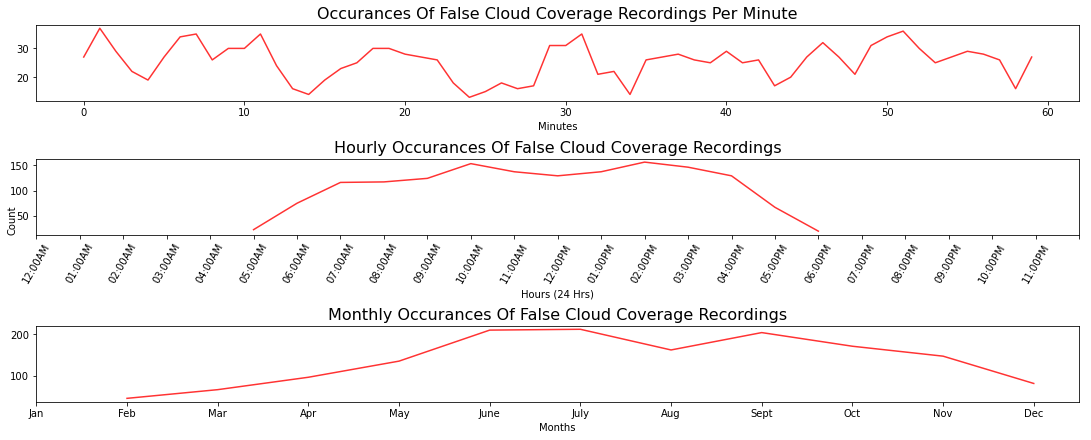

In [134]:
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", 
          "Aug", "Sept", "Oct", "Nov", "Dec"]

HOURS_FMT12 =  ["12:00AM","01:00AM", "02:00AM","03:00AM","04:00AM","05:00AM","06:00AM","07:00AM","08:00AM","09:00AM","10:00AM",
         "11:00AM","12:00PM","01:00PM","02:00PM","03:00PM","04:00PM","05:00PM","06:00PM","07:00PM","08:00PM",
         "09:00PM","10:00PM","11:00PM"," "]

fig, axes = plt.subplots(nrows=3, figsize=(15,6), constrained_layout=True)

# Per Mintue
plt.sca(axes[0])
weather_false_coverage_df.groupby(weather_false_coverage_df["datetime_cpy"].dt.minute)['pyranometer'].count() \
                                    .plot(kind="line", color='red', alpha=0.8 )
plt.xlabel("Minutes")
plt.title("Occurances Of False Cloud Coverage Recordings Per Minute", fontsize=16)


# Per Hour
plt.sca(axes[1])
weather_false_coverage_df.groupby(weather_false_coverage_df["datetime_cpy"].dt.hour)['pyranometer'].count() \
                                    .plot(kind="line", color='red', alpha=0.8 )
plt.xticks(ticks=range(25), labels=HOURS_FMT12, rotation=60)
plt.xlabel("Hours (24 Hrs)")
plt.title("Hourly Occurances Of False Cloud Coverage Recordings", fontsize=16)


# Per Month
plt.sca(axes[2])
weather_false_coverage_df.groupby(weather_false_coverage_df["datetime_cpy"].dt.month)['pyranometer'].count() \
                                    .plot(kind="line", color='red',alpha=0.8)
plt.xticks(ticks=range(12), labels=MONTHS)
plt.xlabel("Months")
plt.title("Monthly Occurances Of False Cloud Coverage Recordings", fontsize=16)

fig.text(0.0, 0.5, 'Count', va='center', rotation='vertical')
plt.show()

Here are some of observations about the frequency of occurances of unknown errors in **total_cloud_coverage_pct** I made, 
- Daily and per Minute - Occurances were uniform across ranges, so nothing specific found so not plotted.
- Hourly - Occurances usually started after 05:00AM, peaked between 08:00AM to 03:00PM and then stopped after 06:00PM.
- Monthly - Occuraces are present throughout the year, but peaked around June to Sept and then started to reduce. Maybe some seasonal effect caused this.

As these occurances are still widely distributed for Minutes Frequency, for now we can go ahead and replace the wrong **total_cloud_coverage_pct** with common occurances in last 5 minutes.

([<matplotlib.axis.XTick at 0x1fbd6c90808>,
 [Text(0, 0, 'Jan'),
  Text(1, 0, 'Feb'),
  Text(2, 0, 'Mar'),
  Text(3, 0, 'Apr'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'Aug'),
  Text(8, 0, 'Sept'),
  Text(9, 0, 'Oct'),
  Text(10, 0, 'Nov'),
  Text(11, 0, 'Dec')])

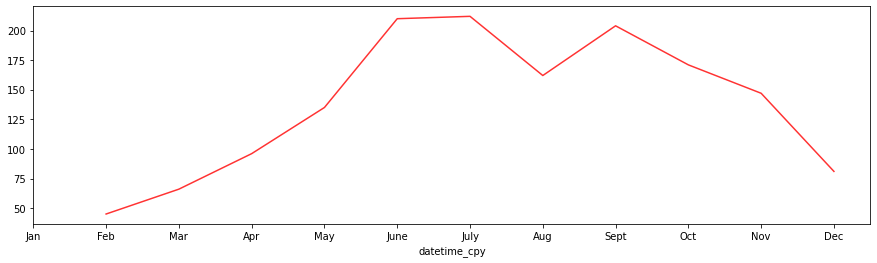